# QCoDeS Example with AMI430

## User guide - described as a series of tests

## Summary of automated tests that the driver goes through

We have performed a lot of stand alone tests (tests with mocked hardware) in qcodes/tests/test_ami430.py. In particular, we have tested: 
- If the driver remembers the internal setpoints if these are given in cartesian, spherical and cylindrical coordinates
- Check that we send to correct setpoint instructions to the individual instruments if inputs are cartesian, spherical or cylindrical coordinates
- Test that we can call the measured parameters (e.g. cartesian_measured) without exceptions occuring. 
- Check that instruments which need to ramp down are given adjustment instructions first
- Check that field limit exceptions are raised properly
- Check that the driver remembers theta and phi coordinates even if the vector norm is zero. 
- Test that a warning is issued when the maximum ramp rate is increased 
- Test that an exception is raised when we try to set a ramp rate which is higher then the maximum allowed value.

Furthermore, in qcodes/tests/test_field_vector.py we have tested if the cartesian to spherical/cylindircal coordinate transformations and visa-versa has been correctly implemented by asserting symmetry rules. 

## Connecting to the individual axis instruments

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt 

from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430, AMI430_3D
from qcodes.math_utils.field_vector import FieldVector

In [2]:
# Check if we can establish communication with the power sources
ix = AMI430("x", address="169.254.146.116", port=7180)
iy = AMI430("y", address="169.254.136.91", port=7180)
iz = AMI430("z", address="169.254.21.127", port=7180)

Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.60s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.62s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.57s


## Working with a single axis

On individual instruments (individual axes), we:

- Test that we can correctly set current values of individual sources
- Test that we can correctly measure current values of individual sources 
- Test that we can put the sources in paused mode 
- Test that the ramp rates are properly set 

In [3]:
# lets test an individual instrument first. We select the z axis. 
instrument = iz

# Since the set method of the driver only excepts fields in Tesla and we want to check if the correct 
# currents are applied, we need to convert target currents to target fields. For this reason we need 
# the coil constant. 
coil_const = instrument._coil_constant
current_rating = instrument._current_rating
current_ramp_limit = instrument._current_ramp_limit
print("coil constant = {} T/A".format(coil_const))
print("current rating = {} A".format(current_rating))
print("current ramp rate limit = {} A/s".format(current_ramp_limit))

coil constant = 0.076 T/A
current rating = 79.1 A
current ramp rate limit = 0.06 A/s


In [5]:
# Let see if we can set and get the field in Tesla 
target_current = 1.0  # [A]  The current we want to set 
target_field = coil_const * target_current  # [T]
print("Target field is {} T".format(target_field))
instrument.field(target_field)

field = instrument.field()  # This gives us the measured field
print("Measured field is {} T".format(field))
# The current should be 
current = field / coil_const
print("Measured current is = {} A".format(current))
# We have verified with manual inspection that the current has indeed ben reached 

Target field is 0.076 T
Measured field is 0.07604 T
Measured current is = 1.0005263157894737 A


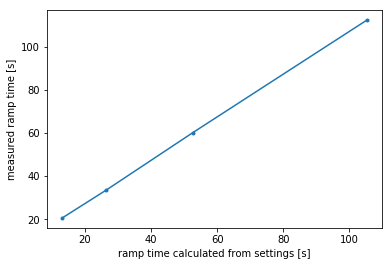

slope = 0.9993355432517128. A value close to one means the correct ramp times are used
offset = 7.364001916301564. An offset indicates that there is a fixed delay is added to a ramp request


In [24]:
# Verify that the ramp rate is indeed how it is specified 
ramp_rate = instrument.ramp_rate()  # get the ramp rate
instrument.field(0)  # make sure we are back at zero amps

target_fields = [0.1, 0.3, 0.7, 1.5]  # [T]
t_setting = []
t_actual = []

for target_field in target_fields:

    current_field = instrument.field()
    ts = abs(target_field - current_field) / ramp_rate
    t_setting.append(ts)
    
    tb = time.time()
    instrument.field(target_field)
    te = time.time()
    ta = te - tb
    t_actual.append(ta)

fig, ax = plt.subplots()
ax.plot(t_setting, t_actual, ".-")
plt.xlabel("ramp time calculated from settings [s]")
plt.ylabel("measured ramp time [s]")
plt.show()
slope, offset = np.polyfit(t_setting, t_actual, 1)
print("slope = {}. A value close to one means the correct ramp times are used".format(slope))
print("offset = {}. An offset indicates that there is a fixed delay is added to a ramp request".format(offset))

In [9]:
# Lets move back to zero Amp
instrument.field(0)

### Note on maximum current ramp rate

The maximum current ramp rate can be increased to a desired value via setting the `current_ramp_limit` parameter. However, this should be done conservatively to avoid quenching the magnet. We strongly recommend to consult to the manual of your particular magnet before making any changes.

## Working with the 3D driver, controlling all 3 axes

With the 3D driver, we:

- Test that the correct set points are reached if we give inputs in cartesian, spherical or cylindrical coordinates 
- Test that we can set theta and phi to non-zero values which are remembered if r is ramped from zero to r > 0. 
- Test that instruments are ramped up and down in the correct order, with ramp downs occuring before ramp ups.


In [3]:
# Lets test the 3D driver now. 
field_limit = [  # If any of the field limit functions are satisfied we are in the safe zone.
    lambda x, y, z: x == 0 and y == 0 and z < 3,  # We can have higher field along the z-axis if x and y are zero.
    lambda x, y, z: np.linalg.norm([x, y, z]) < 2
]

i3d = AMI430_3D(
    "AMI430-3D", 
    ix,
    iy,
    iz,
    field_limit=field_limit
)

In [4]:
def current_to_field(name, current):
    """We cannot set currents directly, so we need to calculate what fields need to be generated for 
    the desired currents"""
    instrument = {"x": ix, "y": iy, "z": iz}[name]
    coil_constant = instrument._coil_constant #  [T/A]
    field = current * coil_constant
    return field

In [12]:
# Lets see if we can set a certain current using cartesian coordinates
current_target = [1.0, 0.5, 1.5]
# calculate the fields needed
field_target = [current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)]
print("field target = {}".format(field_target))
i3d.cartesian(field_target)
field_measured = i3d.cartesian_measured()
print("field measured = {}".format(field_measured))

field target = [0.0386, 0.0121, 0.11399999999999999]
field measured = [0.03816, 0.01211, 0.11384]


In [13]:
# Lets move back to 0,0,0
i3d.cartesian([0, 0, 0])

# Lets see if we can set a certain current using spherical coordinates
current_target = [1.0, 0.5, 1.5]
# calculate the fields needed
field_target_cartesian = [current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)]
# calculate the field target in spherical coordinates 
field_target_spherical = FieldVector(*field_target_cartesian).get_components("r", "theta", "phi")

print("field target = {}".format(field_target_spherical))
i3d.spherical(field_target_spherical)
field_measured = i3d.spherical_measured()
print("field measured = {}".format(field_measured))
# Like before, we see that the current target of 1.0, 0.5, 1.5 A for x, y and z have indeed been reached

field target = [0.1209643335863923, 19.536859161547078, 17.404721375291402]
field measured = [0.12077462481829535, 19.424782613847988, 17.532727661391853]


In [15]:
# Lets move back to 0,0,0
i3d.cartesian([0, 0, 0])

# Lets see if we can set a certain current using cylindrical coordinates
current_target = [1.0, 0.5, 1.5]
# calculate the fields needed
field_target_cartesian = [current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)]
# calculate the field target in cylindrical coordinates 
field_target_cylindrical = FieldVector(*field_target_cartesian).get_components("rho", "phi", "z")

print("field target = {}".format(field_target_cylindrical))
i3d.cylindrical(field_target_cylindrical)
field_measured = i3d.cylindrical_measured()
print("field measured = {}".format(field_measured))
# Like before, we see that the current target of 1.0, 0.5, 1.5 A for x, y and z have indeed been reached

field target = [0.040452070404368677, 17.404721375291402, 0.11399999999999999]
field measured = [0.040235668255914431, 17.51627743673798, 0.11365]


In [16]:
# Test that ramping up and down occurs in the right order,
# that is, first, ramp axes that have ramp down,
# and only then ramp axes that have to ramp up.
current_target = [1.0, 0.75, 1.0]  # We ramp down the z, ramp up y and keep x the same 
# We should see that z is adjusted first, then y. 
# calculate the fields needed
field_target = [current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)]
print("field target = {}".format(field_target))
i3d.cartesian(field_target)
# Manual inspection has shown that z is indeed ramped down before y is ramped up 

field target = [0.0386, 0.01815, 0.076]


In [17]:
# check that an exception is raised when we try to set a field which is out side of the safety limits 
try:
    i3d.cartesian([2.1, 0, 0])
    print("something went wrong... we should not be able to do this :-(")
except:
    print("error successfully raised. The driver does not let you do stupid stuff")

error successfully raised. The driver does not let you do stupid stuff


In [25]:
# Check that the driver remembers theta/phi values if the set point norm is zero

# lets go back to zero field
i3d.cartesian([0, 0, 0])
# Lets set theta and phi to a non zero value but keep the field magnitude at zero
field_target_spherical = [0, 20.0, -40.0]
i3d.spherical(field_target_spherical)
field_measured = i3d.cartesian_measured()
print("1: Measured field = {} T".format(field_measured))

# Note that theta_measured and phi_measured will give random values based on noisy current reading 
# close to zero (this cannot be avoided)
theta_measured = i3d.theta_measured()
print("1: Theta measured = {}".format(theta_measured))
phi_measured = i3d.phi_measured()
print("1: Phi measured = {}".format(phi_measured))

# now lets set the r value
i3d.field(0.4)

field_measured = i3d.cartesian_measured()
print("2: Measured field = {} T".format(field_measured))
# Now the measured angles should be as we intended
theta_measured = i3d.theta_measured()
print("2: Theta measured = {}. We see that the input theta of {} has been "
      "remembered".format(theta_measured, field_target_spherical[1]))

phi_measured = i3d.phi_measured()
print("2: Phi measured = {}. We see that the input phi of {} has been "
      "remembered".format(phi_measured, field_target_spherical[2]))

1: Measured field = [-0.00013, -1e-05, 3e-05] T
1: Theta measured = 98.72079692816342
1: Phi measured = 180.0
2: Measured field = [0.10484, -0.08797, 0.37558] T
2: Theta measured = 20.032264760097508. We see that the input theta of 20.0 has been remembered
2: Phi measured = -40.007172479040996. We see that the input phi of -40.0 has been remembered


### Simultaneous ramping mode

...